In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from dataset import *
from torch.utils.data import DataLoader
import torch.distributions as dist
from torch import optim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
dataset = np.load("sketchrnn_cat.full.npz", encoding='latin1',allow_pickle=True)
data = np.concatenate((dataset['train'],dataset['valid'],dataset['test']))
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

In [4]:
class Encoder(nn.Module):
    def __init__(self,
                 hidden_size=256,
                 z_size=128,
                 dropout=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.rnn = nn.GRU(5, self.hidden_size, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc_mu = nn.Linear(2*self.hidden_size, self.z_size)
        self.fc_logvar = nn.Linear(2*self.hidden_size, self.z_size)
        
    def forward(self,inputs):
        _, hidden = self.rnn(inputs)
        hidden_cat = torch.cat(hidden.split(1,0),2).squeeze(0)
        mu = self.fc_mu(hidden_cat)
        logvar = self.fc_logvar(hidden_cat)
        return mu,logvar

In [5]:
class Decoder(nn.Module):
    def __init__(self,
                 hidden_size=256,
                 z_size=128,
                 dropout=0.5):
        super(Decoder, self).__init__()
        self.rnn = nn.GRU(z_size+5, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(z_size,hidden_size)
        
    def init_state(self,z):
        return F.tanh(self.fc(z).unsqueeze(0))
    
    def forward(self,inputs,z):
        hidden = self.init_state(z)
        zs = z.unsqueeze(1).expand(-1,inputs.size(1),-1)
        inputs_z = torch.cat([inputs,zs],dim=2)
        return self.rnn(inputs_z,hidden)

In [6]:
class SketchRNN(nn.Module):
    def __init__(self,
                 enc_hidden_size=256,
                 dec_hidden_size=512,
                 z_size=128,
                 dropout=0.5,
                 M=20):
        super(SketchRNN, self).__init__()
        self.dec_hidden_size = dec_hidden_size
        self.M = M
        self.encoder = Encoder(enc_hidden_size,z_size,dropout)
        self.decoder = Decoder(dec_hidden_size,z_size,dropout)
        self.gmm = nn.Linear(dec_hidden_size,6*M+3)
        
    def forward(self,inputs):
        enc_inputs = inputs[:,1:,:]
        mu,logvar = self.encoder(enc_inputs)
        z = self.reparameterize(mu,logvar)
        
        dec_inputs = inputs[:,:-1,:]
        outputs,_ = self.decoder(dec_inputs,z)
        outputs = self.gmm(outputs.contiguous().view(-1,self.dec_hidden_size))
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
        
        return z, mu, logvar ,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def get_mixture_coef(self,outputs):
        z_pen_logits = outputs[:, 0:3]  # pen states
        z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.split(outputs[:, 3:], self.M, 1)
        # process output z's into MDN paramters

        # softmax all the pi's and pen states:
        z_pi = F.softmax(z_pi,1)
        z_pen = F.softmax(z_pen_logits,1)

        # exponentiate the sigmas and also make corr between -1 and 1.
        z_sigma1 = torch.exp(z_sigma1)
        z_sigma2 = torch.exp(z_sigma2)
        z_corr = F.tanh(z_corr)

        r = [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen, z_pen_logits]
        return r
    
    def generate(self,seq_len,z,temp=0.5):
        sample = Variable(torch.Tensor([0,0,1,0,0]),requires_grad=False).view(1,1,5).cuda()
        hidden = self.decoder.init_state(z)
        
        def bivariate_normal(m1,m2,s1,s2,rho,temp=1.0):
            mean = [m1, m2]
            s1 *= temp * temp
            s2 *= temp * temp
            cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
            x = np.random.multivariate_normal(mean, cov, 1,check_valid='ignore')
            return x[0][0], x[0][1]
        
        def adjust_temp(pdf):
            pdf = pdf.log().div(temp)
            pdf -= pdf.max()
            pdf = pdf.exp()
            pdf /= pdf.sum()
            return pdf
        
        for _ in range(seq_len):
            inputs = sample[:,-1:,:]
            inputs_z = torch.cat([inputs,z.unsqueeze(1)],dim=2)
            outputs,hidden = self.decoder.rnn(inputs_z,hidden)
            outputs = self.gmm(outputs.contiguous().view(-1,self.dec_hidden_size))
            o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
            
            state = Variable(torch.zeros(1,1,5),requires_grad=False).cuda()
            pen_status = dist.Categorical(adjust_temp(o_pen.view(-1))).sample()
            state[:,:,pen_status.data[0]+2] = 1
            
            M_id = dist.Categorical(adjust_temp(o_pi.view(-1))).sample().data[0]
            mu_1 = o_mu1[0,M_id].data
            mu_2 = o_mu2[0,M_id].data
            sigma_1 = o_sigma1[0,M_id].data
            sigma_2 = o_sigma2[0,M_id].data
            o_corr = o_corr[0,M_id].data
           
            x,y = bivariate_normal(mu_1,mu_2,sigma_1,sigma_2,o_corr,temp=temp)
            state[:,:,0] = x
            state[:,:,1] = y
            
            sample = torch.cat([sample,state],dim=1)
            
            if pen_status.cpu().data.numpy() == 2:
                break
        return sample

In [7]:
def get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr,
                     z_pen_logits, x1_data, x2_data, pen_data):
        """Returns a loss fn based on eq #26 of http://arxiv.org/abs/1308.0850."""
        # This represents the L_R only (i.e. does not include the KL loss term).
        
        def normal_2d(x1, x2, mu1, mu2, s1, s2, rho):
            """Returns result of eq # 24 of http://arxiv.org/abs/1308.0850."""
            norm1 = x1 - mu1
            norm2 = x2 - mu2
            s1s2 = s1*s2
            # eq 25
            z = norm1.div(s1).pow(2) + norm2.div(s2).pow(2) - 2*(rho*norm1*norm2).div(s1s2)
            neg_rho = 1 - rho.pow(2)
            result = (-z).div(2*neg_rho).exp()
            denom = 2 * np.pi * s1s2 * torch.sqrt(neg_rho)
            result = result.div(denom)
            return result
        
        result0 = normal_2d(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2,z_corr)
        epsilon = 1e-6
        # result1 is the loss wrt pen offset (L_s in equation 9 of
        # https://arxiv.org/pdf/1704.03477.pdf)
        result1 = result0*z_pi
        result1 = torch.sum(result1, 1)
        result1 = -torch.log(result1 + epsilon)  # avoid log(0)
        
        fs = 1.0 - pen_data[:, 2]  # use training data for this
        result1 = result1*fs
        result1_mean = result1.sum() / fs.sum()
        
        _,labels = pen_data.max(1)
        result2 = F.cross_entropy(z_pen_logits,labels)
        
        result = result1_mean + result2
        return result
    
def KLD(mu,logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())    

In [8]:
sketch = Sketch(data)
training_data = DataLoader(sketch ,batch_size=100, shuffle=True,collate_fn=collate_fn_, num_workers=8)

In [9]:
model = SketchRNN().cuda()
train_step = optim.Adam(model.parameters(),lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(train_step, step_size=30, gamma=0.9999)

/home/robotics/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [10]:
model.train()
g_step = 0

for epcoch in range(100):
    loss_ = []
    
    for data in training_data:
        data = Variable(data).cuda()
        z, mu, logvar, o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = model(data)
        
        target = data[:,1:,:]
        target = target.contiguous().view(-1,5)
        x1_data, x2_data, eos_data, eoc_data, cont_data = target.split(1,1)
        pen_data = torch.cat([eos_data, eoc_data, cont_data], 1)
        
        kl_loss = KLD(mu,logvar)
        rec_loss = get_lossfunc(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, 
                                o_corr,o_pen_logits, x1_data, x2_data, pen_data)
        
        eta_step = 1 - (1 - 0.01)*(0.9995**g_step)
        loss = rec_loss + 0.5*eta_step*torch.max(kl_loss,Variable(torch.Tensor([0.2])).cuda().detach())
        
        train_step.zero_grad()
        loss.backward()
        for p in model.parameters():
            p.grad.data.clamp_(-1,1)
        train_step.step()
        scheduler.step()
        loss_.append(loss.data[0])
        g_step+=1
    
    if epcoch % 1 ==0:
        print np.mean(loss_)

1.0148291881
0.613580027351
0.521526919768
0.47099332795
0.437252658568
0.412678551711
0.392044629788
0.374888725137
0.361230455767
0.349945780726
0.339207209366
0.330102196783
0.321634333775
0.314487990975
0.307335757736
0.301285048877
0.295516633862
0.290063889981
0.28565707762
0.280707580203
0.276509488821
0.272658989502
0.269441734725
0.265327345453
0.262150039512
0.259774208905
0.255300832936
0.25280044906
0.249871486293
0.247451776261
0.245164624531
0.241674987128
0.239670852015
0.236872987036
0.23514169181
0.23341007435
0.231106347353
0.22918179862
0.226658948007
0.224976391603
0.223469707372
0.221796380092
0.21954984036
0.217814892718
0.21640017226
0.2149339855
0.212672480695
0.211128082655
0.209773846004
0.208511355228
0.207444915645
0.205929920525
0.204144011113
0.202688226787
0.201688752963
0.200236076098
0.199031938596
0.197649682907
0.195966648965
0.195168980763
0.193783319771
0.193000377074
0.191425373835
0.190378248598
0.189192408472
0.188084842152
0.186965998617
0.18622

In [11]:
model.eval()

SketchRNN(
  (encoder): Encoder(
    (rnn): GRU(5, 256, batch_first=True, dropout=0.5, bidirectional=True)
    (fc_mu): Linear(in_features=512, out_features=128)
    (fc_logvar): Linear(in_features=512, out_features=128)
  )
  (decoder): Decoder(
    (rnn): GRU(133, 512, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=128, out_features=512)
  )
  (gmm): Linear(in_features=512, out_features=123)
)

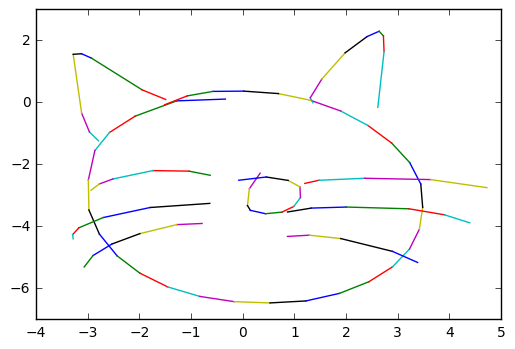

In [53]:
s = model.generate(250,Variable(torch.randn(1,128)).cuda(),temp=0.4)
s = s[0]
x = np.cumsum(s.cpu().data.numpy()[:,0])
y = np.cumsum(s.cpu().data.numpy()[:,1])

for i in range(1,s.size(0)):
    if s.cpu().data.numpy()[i,2]:
        plt.plot(x[i:i+2],-y[i:i+2])

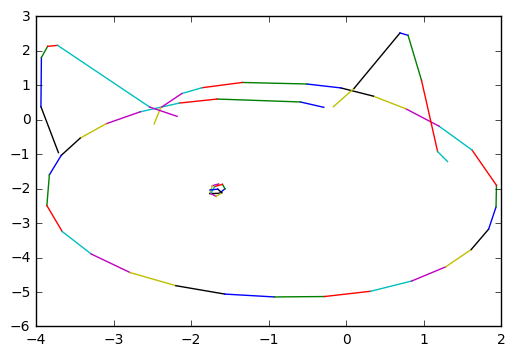

In [69]:
s = model.generate(250,z[:1],temp=0.6)
s = s[0]
x = np.cumsum(s.cpu().data.numpy()[:,0])
y = np.cumsum(s.cpu().data.numpy()[:,1])

for i in range(1,s.size(0)):
    if s.cpu().data.numpy()[i,2]:
        plt.plot(x[i:i+2],-y[i:i+2])

In [37]:
torch.save(model.state_dict(),'model_full.pth')

/home/robotics/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1, Mean Loss: 1.6997909338102428
Epoch 2, Mean Loss: 0.9618710861840379
Epoch 3, Mean Loss: 0.7833101041273239
Epoch 4, Mean Loss: 0.6885446403004708
Epoch 5, Mean Loss: 0.6241438675911055
Epoch 6, Mean Loss: 0.5738686293090155
Epoch 7, Mean Loss: 0.5360270019518126
Epoch 8, Mean Loss: 0.5025691011356651
Epoch 9, Mean Loss: 0.47809052795445156
Epoch 10, Mean Loss: 0.45660134630465726
Epoch 11, Mean Loss: 0.43582849628334747
Epoch 12, Mean Loss: 0.41962104037814185
Epoch 13, Mean Loss: 0.40406853903871065
Epoch 14, Mean Loss: 0.39097689611649294
Epoch 15, Mean Loss: 0.37786651806000177
Epoch 16, Mean Loss: 0.36721910358568943
Epoch 17, Mean Loss: 0.36014924957117905
Epoch 18, Mean Loss: 0.3502013497396347
Epoch 19, Mean Loss: 0.339459030726634
Epoch 20, Mean Loss: 0.3323305802881171
Epoch 21, Mean Loss: 0.32528329743157836
Epoch 22, Mean Loss: 0.3177602318448758
Epoch 23, Mean Loss: 0.31268389447839984
Epoch 24, Mean Loss: 0.30422029363999675
Epoch 25, Mean Loss: 0.298944346880147

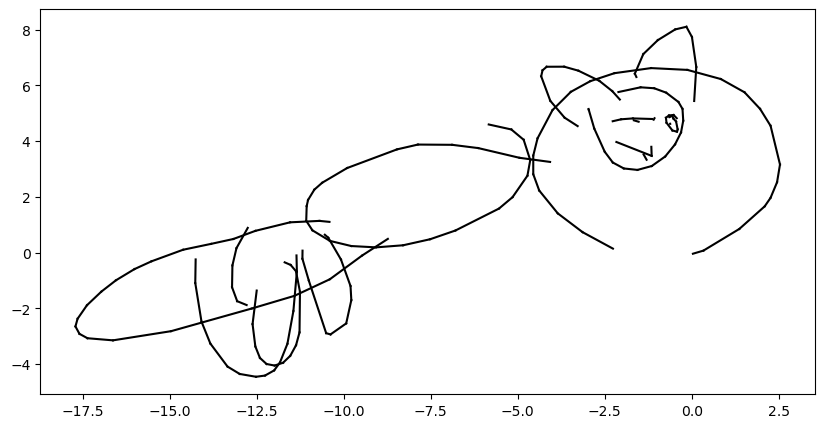

In [15]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.distributions as dist
from torch import optim
import matplotlib.pyplot as plt

# Load the dataset with allow_pickle=True
dataset = np.load("sketchrnn_cat.full.npz", encoding='latin1', allow_pickle=True)

# Concatenate the train, validation, and test datasets
data = np.concatenate((dataset['train'], dataset['valid'], dataset['test']))

# Assuming purify and normalize are functions defined elsewhere
data = purify(data)
data = normalize(data)

# Assuming max_size is defined elsewhere
Nmax = max_size(data)

##############################
# Define the Network Modules #
##############################

class Encoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.rnn = nn.GRU(5, self.hidden_size, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc_mu = nn.Linear(2 * self.hidden_size, self.z_size)
        self.fc_logvar = nn.Linear(2 * self.hidden_size, self.z_size)
        
    def forward(self, inputs):
        _, hidden = self.rnn(inputs)
        # hidden is of shape (num_layers * num_directions, batch, hidden_size)
        hidden_cat = torch.cat(hidden.split(1, 0), 2).squeeze(0)
        mu = self.fc_mu(hidden_cat)
        logvar = self.fc_logvar(hidden_cat)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.5):
        super(Decoder, self).__init__()
        self.rnn = nn.GRU(z_size + 5, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(z_size, hidden_size)
        
    def init_state(self, z):
        # Create an initial hidden state from z
        return torch.tanh(self.fc(z).unsqueeze(0))
    
    def forward(self, inputs, z):
        hidden = self.init_state(z)
        zs = z.unsqueeze(1).expand(-1, inputs.size(1), -1)
        inputs_z = torch.cat([inputs, zs], dim=2)
        return self.rnn(inputs_z, hidden)

class SketchRNN(nn.Module):
    def __init__(self, enc_hidden_size=256, dec_hidden_size=512, z_size=128, dropout=0.5, M=20):
        super(SketchRNN, self).__init__()
        self.dec_hidden_size = dec_hidden_size
        self.M = M
        self.encoder = Encoder(enc_hidden_size, z_size, dropout)
        self.decoder = Decoder(dec_hidden_size, z_size, dropout)
        self.gmm = nn.Linear(dec_hidden_size, 6 * M + 3)
        
    def forward(self, inputs):
        enc_inputs = inputs[:, 1:, :]
        mu, logvar = self.encoder(enc_inputs)
        z = self.reparameterize(mu, logvar)
        
        dec_inputs = inputs[:, :-1, :]
        outputs, _ = self.decoder(dec_inputs, z)
        outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
        
        return z, mu, logvar, o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu
        
    def get_mixture_coef(self, outputs):
        z_pen_logits = outputs[:, 0:3]  # pen state logits
        z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.split(outputs[:, 3:], self.M, 1)
        
        # Softmax the pi's and pen states
        z_pi = F.softmax(z_pi, dim=1)
        z_pen = F.softmax(z_pen_logits, dim=1)
        
        # Exponentiate sigmas and constrain corr between -1 and 1.
        z_sigma1 = torch.exp(z_sigma1)
        z_sigma2 = torch.exp(z_sigma2)
        z_corr = torch.tanh(z_corr)
        
        return z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen, z_pen_logits
    
    def generate(self, seq_len, z, temp=0.5):
        # Start with the initial stroke [0, 0, 1, 0, 0]
        sample = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32, device=z.device).view(1, 1, 5)
        hidden = self.decoder.init_state(z)
        
        # Helper functions:
        def bivariate_normal(m1, m2, s1, s2, rho, temp=1.0):
            mean = [m1, m2]
            # Adjust sigma by temperature
            s1 = s1 * (temp ** 2)
            s2 = s2 * (temp ** 2)
            cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
            sample_np = np.random.multivariate_normal(mean, cov, 1, check_valid='ignore')
            return sample_np[0][0], sample_np[0][1]
        
        def adjust_temp(pdf):
            pdf = torch.log(pdf) / temp
            pdf = pdf - torch.max(pdf)
            pdf = torch.exp(pdf)
            pdf = pdf / torch.sum(pdf)
            return pdf
        
        for _ in range(seq_len):
            inputs = sample[:, -1:, :]
            inputs_z = torch.cat([inputs, z.unsqueeze(1)], dim=2)
            outputs, hidden = self.decoder.rnn(inputs_z, hidden)
            outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
            o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
            
            state = torch.zeros(1, 1, 5, device=z.device)
            pen_status = dist.Categorical(adjust_temp(o_pen.view(-1))).sample().item()
            state[:, :, pen_status + 2] = 1  # Set the pen state
            
            M_id = dist.Categorical(adjust_temp(o_pi.view(-1))).sample().item()
            mu_1 = o_mu1[0, M_id].item()
            mu_2 = o_mu2[0, M_id].item()
            sigma_1 = o_sigma1[0, M_id].item()
            sigma_2 = o_sigma2[0, M_id].item()
            corr = o_corr[0, M_id].item()
           
            x, y = bivariate_normal(mu_1, mu_2, sigma_1, sigma_2, corr, temp=temp)
            state[:, :, 0] = x
            state[:, :, 1] = y
            
            sample = torch.cat([sample, state], dim=1)
            
            if pen_status == 2:  # if the pen state indicates end-of-drawing
                break
        return sample

##############################
# Loss Functions and Helpers #
##############################

def get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr,
                 z_pen_logits, x1_data, x2_data, pen_data):
    """Returns the reconstruction loss as described in the SketchRNN paper."""
    def normal_2d(x1, x2, mu1, mu2, s1, s2, rho):
        norm1 = x1 - mu1
        norm2 = x2 - mu2
        s1s2 = s1 * s2
        z = (norm1 / s1).pow(2) + (norm2 / s2).pow(2) - 2 * (rho * norm1 * norm2) / s1s2
        neg_rho = 1 - rho.pow(2)
        result = torch.exp(-z / (2 * neg_rho)) / (2 * np.pi * s1s2 * torch.sqrt(neg_rho))
        return result
    
    result0 = normal_2d(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr)
    epsilon = 1e-6
    result1 = result0 * z_pi
    result1 = torch.sum(result1, dim=1)
    result1 = -torch.log(result1 + epsilon)
    
    fs = 1.0 - pen_data[:, 2]  # use training data for weighting
    result1 = result1 * fs
    result1_mean = result1.sum() / fs.sum()
    
    _, labels = pen_data.max(dim=1)
    result2 = F.cross_entropy(z_pen_logits, labels)
    
    return result1_mean + result2

def KLD(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

##############################
# Training Setup and Loop    #
##############################

# Assuming Sketch (a dataset class) and collate_fn_ are defined elsewhere
sketch = Sketch(data)
training_data = DataLoader(sketch, batch_size=512, shuffle=True, collate_fn=collate_fn_, num_workers=8)

model = SketchRNN().cuda()
train_step = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(train_step, step_size=30, gamma=0.9999)

model.train()
g_step = 0

for epoch in range(100):
    loss_list = []
    
    for batch in training_data:
        batch = batch.cuda()
        z, mu, logvar, o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = model(batch)
        
        target = batch[:, 1:, :].contiguous().view(-1, 5)
        x1_data, x2_data, eos_data, eoc_data, cont_data = target.split(1, dim=1)
        pen_data = torch.cat([eos_data, eoc_data, cont_data], dim=1)
        
        kl_loss = KLD(mu, logvar)
        rec_loss = get_lossfunc(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2,
                                o_corr, o_pen_logits, x1_data, x2_data, pen_data)
        
        eta_step = 1 - (1 - 0.01) * (0.9995 ** g_step)
        kl_bound = torch.tensor(0.2, device=batch.device)
        loss = rec_loss + 0.5 * eta_step * torch.max(kl_loss, kl_bound)
        
        train_step.zero_grad()
        loss.backward()
        for p in model.parameters():
            p.grad.data.clamp_(-1, 1)
        train_step.step()
        scheduler.step()
        
        loss_list.append(loss.item())
        g_step += 1
    
    if epoch % 1 == 0:
        mean_loss = np.mean(loss_list)
        print(f"Epoch {epoch + 1}, Mean Loss: {mean_loss}")

##############################
# Generation and Plotting    #
##############################

model.eval()
# Generate a new latent vector for sampling
z_sample = torch.randn(1, 128, device="cuda")
s = model.generate(250, z_sample, temp=0.6)
s = s[0]
s_np = s.cpu().numpy()
x = np.cumsum(s_np[:, 0])
y = np.cumsum(s_np[:, 1])

plt.figure(figsize=(10, 5))
for i in range(1, s.size(0)):
    if s_np[i, 2]:
        plt.plot(x[i:i+2], -y[i:i+2], 'k-')
plt.show()

torch.save(model.state_dict(), 'model_full.pth')


In [30]:
model.eval()
z = torch.randn(1, 128).cuda()
generator = SketchGenerator(model, z, temp=0.6)

strokes = []
current_stroke = []

while True:
    step = generator.next_step()
    if step is None:
        break
    dx, dy, pen_state = step
    current_stroke.append((dx, dy))
    
    if pen_state == 0:  # End of stroke
        strokes.append(current_stroke)
        current_stroke = []

if current_stroke:  # Add the last unfinished stroke
    strokes.append(current_stroke)

# Plotting
plt.figure(figsize=(10, 5))
current_pos = (0, 0)
for stroke in strokes:
    x = [current_pos[0]]
    y = [current_pos[1]]
    for dx, dy in stroke:
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
    plt.plot(x, -np.array(y), 'k-')  # Negative y for natural drawing
    current_pos = (x[-1], y[-1])
plt.axis('equal')
plt.show()

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

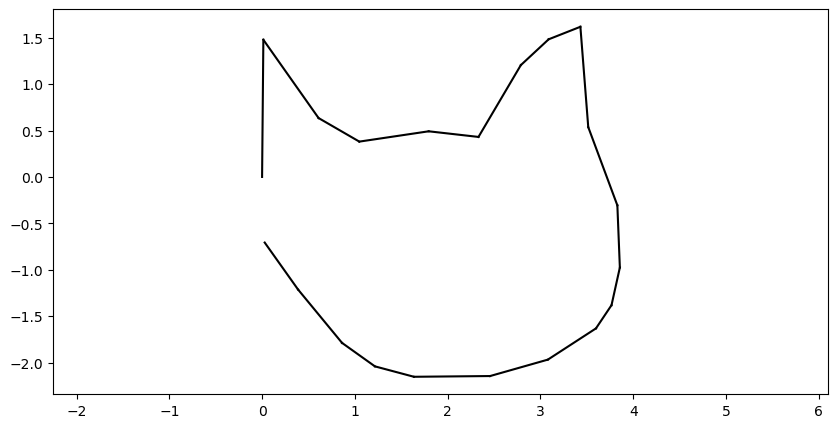

In [35]:
class SketchGenerator:
    def __init__(self, model, z, temp=0.3):
        self.model = model
        self.z = z
        self.temp = temp
        self.hidden = model.decoder.init_state(z)
        # Initial input: [dx, dy, eos, eoc, cont] = [0,0,1,0,0]
        self.last_input = torch.tensor([[0, 0, 1, 0, 0]], dtype=torch.float32, device=z.device).unsqueeze(1)  # Shape: (1, 1, 5)
        self.done = False

    def next_step(self):
        if self.done:
            return None
        
        # Prepare input with latent vector
        z_expanded = self.z.unsqueeze(1)  # Shape: (1, 1, 128)
        inputs_z = torch.cat([self.last_input, z_expanded], dim=2)  # Shape: (1, 1, 133)
        
        # Pass through the decoder
        outputs, self.hidden = self.model.decoder.rnn(inputs_z, self.hidden)
        outputs = self.model.gmm(outputs.view(-1, self.model.dec_hidden_size))
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.model.get_mixture_coef(outputs)
        
        # Adjust temperature for sampling
        def adjust_temp(probs, temp):
            probs = torch.log(probs) / temp
            probs = probs - torch.max(probs)
            probs = torch.exp(probs)
            return probs / torch.sum(probs)
        
        # Sample pen state
        pen_probs = F.softmax(o_pen_logits, dim=1)[0]
        pen_probs = adjust_temp(pen_probs, self.temp)
        pen_status = torch.multinomial(pen_probs, 1).item()
        
        if pen_status == 1:  # End of drawing
            self.done = True
            return None
        
        # Sample mixture component
        pi_probs = adjust_temp(o_pi[0], self.temp)
        M_id = torch.multinomial(pi_probs, 1).item()
        
        # Get mixture parameters
        mu1 = o_mu1[0, M_id].item()
        mu2 = o_mu2[0, M_id].item()
        sigma1 = o_sigma1[0, M_id].item() * self.temp**2
        sigma2 = o_sigma2[0, M_id].item() * self.temp**2
        corr = o_corr[0, M_id].item()
        
        # Sample from bivariate normal
        mean = [mu1, mu2]
        cov = [[sigma1**2, corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]
        try:
            x, y = np.random.multivariate_normal(mean, cov)
        except:
            x, y = mu1, mu2
        
        # Update last input for next step
        self.last_input = torch.zeros_like(self.last_input)
        self.last_input[0, 0, 0] = x
        self.last_input[0, 0, 1] = y
        self.last_input[0, 0, pen_status + 2] = 1  # Set pen state
        
        return (x, y, pen_status)

model.eval()
z = torch.randn(1, 128).cuda()
generator = SketchGenerator(model, z, temp=0.6)

strokes = []
current_stroke = []

while True:
    step = generator.next_step()
    if step is None:
        break
    dx, dy, pen_state = step
    current_stroke.append((dx, dy))
    
    if pen_state == 0:  # End of stroke
        strokes.append(current_stroke)
        current_stroke = []

if current_stroke:  # Add the last unfinished stroke
    strokes.append(current_stroke)

# Plotting
plt.figure(figsize=(10, 5))
current_pos = (0, 0)
for stroke in strokes:
    x = [current_pos[0]]
    y = [current_pos[1]]
    for dx, dy in stroke:
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
    plt.plot(x, -np.array(y), 'k-')  # Negative y for natural drawing
    current_pos = (x[-1], y[-1])
plt.axis('equal')
plt.show()

In [36]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.distributions as dist
from torch import optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class Encoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.rnn = nn.GRU(5, self.hidden_size, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc_mu = nn.Linear(2 * self.hidden_size, self.z_size)
        self.fc_logvar = nn.Linear(2 * self.hidden_size, self.z_size)
        
    def forward(self, inputs):
        _, hidden = self.rnn(inputs)
        # hidden is of shape (num_layers * num_directions, batch, hidden_size)
        hidden_cat = torch.cat(hidden.split(1, 0), 2).squeeze(0)
        mu = self.fc_mu(hidden_cat)
        logvar = self.fc_logvar(hidden_cat)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.0):  # Changed dropout to 0 to avoid warning
        super(Decoder, self).__init__()
        self.rnn = nn.GRU(z_size + 5, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(z_size, hidden_size)
        
    def init_state(self, z):
        # Create an initial hidden state from z
        return torch.tanh(self.fc(z).unsqueeze(0))
    
    def forward(self, inputs, z):
        hidden = self.init_state(z)
        zs = z.unsqueeze(1).expand(-1, inputs.size(1), -1)
        inputs_z = torch.cat([inputs, zs], dim=2)
        return self.rnn(inputs_z, hidden)

class SketchRNN(nn.Module):
    def __init__(self, enc_hidden_size=256, dec_hidden_size=512, z_size=128, dropout=0.0, M=20):
        super(SketchRNN, self).__init__()
        self.dec_hidden_size = dec_hidden_size
        self.M = M
        self.encoder = Encoder(enc_hidden_size, z_size, dropout)
        self.decoder = Decoder(dec_hidden_size, z_size, dropout)
        self.gmm = nn.Linear(dec_hidden_size, 6 * M + 3)
        
    def forward(self, inputs):
        enc_inputs = inputs[:, 1:, :]
        mu, logvar = self.encoder(enc_inputs)
        z = self.reparameterize(mu, logvar)
        
        dec_inputs = inputs[:, :-1, :]
        outputs, _ = self.decoder(dec_inputs, z)
        outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
        
        return z, mu, logvar, o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu
        
    def get_mixture_coef(self, outputs):
        z_pen_logits = outputs[:, 0:3]  # pen state logits
        z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.split(outputs[:, 3:], self.M, 1)
        
        # Softmax the pi's and pen states
        z_pi = F.softmax(z_pi, dim=1)
        z_pen = F.softmax(z_pen_logits, dim=1)
        
        # Exponentiate sigmas and constrain corr between -1 and 1.
        z_sigma1 = torch.exp(z_sigma1)
        z_sigma2 = torch.exp(z_sigma2)
        z_corr = torch.tanh(z_corr)
        
        return z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen, z_pen_logits
    
    def generate_step_by_step(self, seq_len=250, z=None, temperature=0.6):
        """
        Generate a sketch one stroke at a time
        
        Args:
            seq_len: Maximum sequence length to generate
            z: Latent vector (if None, a random one will be generated)
            temperature: Controls randomness (lower = more deterministic)
            
        Returns:
            List of strokes, each containing [dx, dy, pen_down, pen_up, pen_end]
        """
        device = next(self.parameters()).device
        
        # Generate a random latent vector if not provided
        if z is None:
            z = torch.randn(1, 128, device=device)
        
        # Start with initial stroke [0, 0, 1, 0, 0]
        sample = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32, 
                              device=device).view(1, 1, 5)
        hidden = self.decoder.init_state(z)
        
        # Lists to store the generated strokes
        all_strokes = []
        
        # Helper function for bivariate normal distribution sampling
        def bivariate_normal(m1, m2, s1, s2, rho, temp=1.0):
            mean = [m1, m2]
            s1 = s1 * (temp ** 2)
            s2 = s2 * (temp ** 2)
            cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
            sample_np = np.random.multivariate_normal(mean, cov, 1, check_valid='ignore')
            return sample_np[0][0], sample_np[0][1]
        
        # Helper function to adjust temperature for sampling
        def adjust_temp(pdf):
            pdf = torch.log(pdf) / temperature
            pdf = pdf - torch.max(pdf)
            pdf = torch.exp(pdf)
            pdf = pdf / torch.sum(pdf)
            return pdf
        
        # Generate strokes one by one
        for _ in range(seq_len):
            inputs = sample[:, -1:, :]
            inputs_z = torch.cat([inputs, z.unsqueeze(1)], dim=2)
            outputs, hidden = self.decoder.rnn(inputs_z, hidden)
            outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
            o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
            
            state = torch.zeros(1, 1, 5, device=device)
            pen_status = torch.distributions.Categorical(adjust_temp(o_pen.view(-1))).sample().item()
            state[:, :, pen_status + 2] = 1  # Set the pen state
            
            M_id = torch.distributions.Categorical(adjust_temp(o_pi.view(-1))).sample().item()
            mu_1 = o_mu1[0, M_id].item()
            mu_2 = o_mu2[0, M_id].item()
            sigma_1 = o_sigma1[0, M_id].item()
            sigma_2 = o_sigma2[0, M_id].item()
            corr = o_corr[0, M_id].item()
            
            x, y = bivariate_normal(mu_1, mu_2, sigma_1, sigma_2, corr, temp=temperature)
            state[:, :, 0] = x
            state[:, :, 1] = y
            
            # Store the current stroke
            all_strokes.append(state.cpu().numpy()[0, 0])
            
            # Add the new stroke to the sample
            sample = torch.cat([sample, state], dim=1)
            
            # Stop if pen_status indicates end of drawing
            if pen_status == 2:
                break
        
        # Convert to numpy array for easier handling
        all_strokes = np.array(all_strokes)
        
        return all_strokes

def visualize_step_by_step(strokes, save_path=None):
    """
    Visualize the sketch generation process
    
    Args:
        strokes: Array of strokes (dx, dy, pen_down, pen_up, pen_end)
        save_path: Path to save the animation (optional)
        
    Returns:
        Animation object and HTML display object
    """
    # Calculate absolute coordinates
    x_coords = np.cumsum(strokes[:, 0])
    y_coords = np.cumsum(strokes[:, 1])
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(min(x_coords) - 10, max(x_coords) + 10)
    ax.set_ylim(min(y_coords) - 10, max(y_coords) + 10)
    ax.axis('off')
    ax.set_title('Sketch Generation Process')
    
    # Initialize empty line
    line, = ax.plot([], [], 'k-', lw=2)
    
    # Initialize function for animation
    def init():
        line.set_data([], [])
        return line,
    
    # Update function for animation
    def update(frame):
        # Get coordinates up to current frame
        x = x_coords[:frame+1]
        y = y_coords[:frame+1]
        
        # Check pen states to determine where to break the line
        pen_states = strokes[:frame+1, 2:5]
        
        # Find indices where pen is lifted (pen_up = 1)
        breaks = np.where(pen_states[:, 1] == 1)[0]
        
        # If there are breaks, draw multiple line segments
        if len(breaks) > 0:
            segments_x = []
            segments_y = []
            
            start_idx = 0
            for break_idx in breaks:
                if break_idx > start_idx:
                    segments_x.append(x[start_idx:break_idx+1])
                    segments_y.append(y[start_idx:break_idx+1])
                start_idx = break_idx + 1
            
            # Add the last segment if it exists
            if start_idx < len(x):
                segments_x.append(x[start_idx:])
                segments_y.append(y[start_idx:])
            
            # Clear previous lines and draw all segments
            ax.clear()
            ax.set_xlim(min(x_coords) - 10, max(x_coords) + 10)
            ax.set_ylim(min(y_coords) - 10, max(y_coords) + 10)
            ax.axis('off')
            ax.set_title('Sketch Generation Process')
            
            for seg_x, seg_y in zip(segments_x, segments_y):
                ax.plot(seg_x, -seg_y, 'k-', lw=2)  # Negate y for proper orientation
        else:
            line.set_data(x, -y)  # Negate y for proper orientation
        
        return line,
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(strokes),
                         init_func=init, blit=True, interval=50)
    
    # Save animation if path is provided
    if save_path:
        anim.save(save_path, writer='ffmpeg', fps=20)
    
    # Display the animation
    plt.close()  # Prevent duplicate display in Jupyter
    return anim, HTML(anim.to_jshtml())

def main():
    # Create and load the model
    model = SketchRNN()
    model.load_state_dict(torch.load('model_full.pth', map_location='cpu', weights_only=True))
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Generate a random latent vector
    z_sample = torch.randn(1, 128, device=device)
    
    # Generate sketch step by step
    strokes = model.generate_step_by_step(seq_len=250, z=z_sample, temperature=0.6)
    
    # Visualize the sketch generation process
    anim, html_display = visualize_step_by_step(strokes, save_path='sketch_animation.mp4')
    
    # Display the animation
    return html_display

if __name__ == "__main__":
    main()


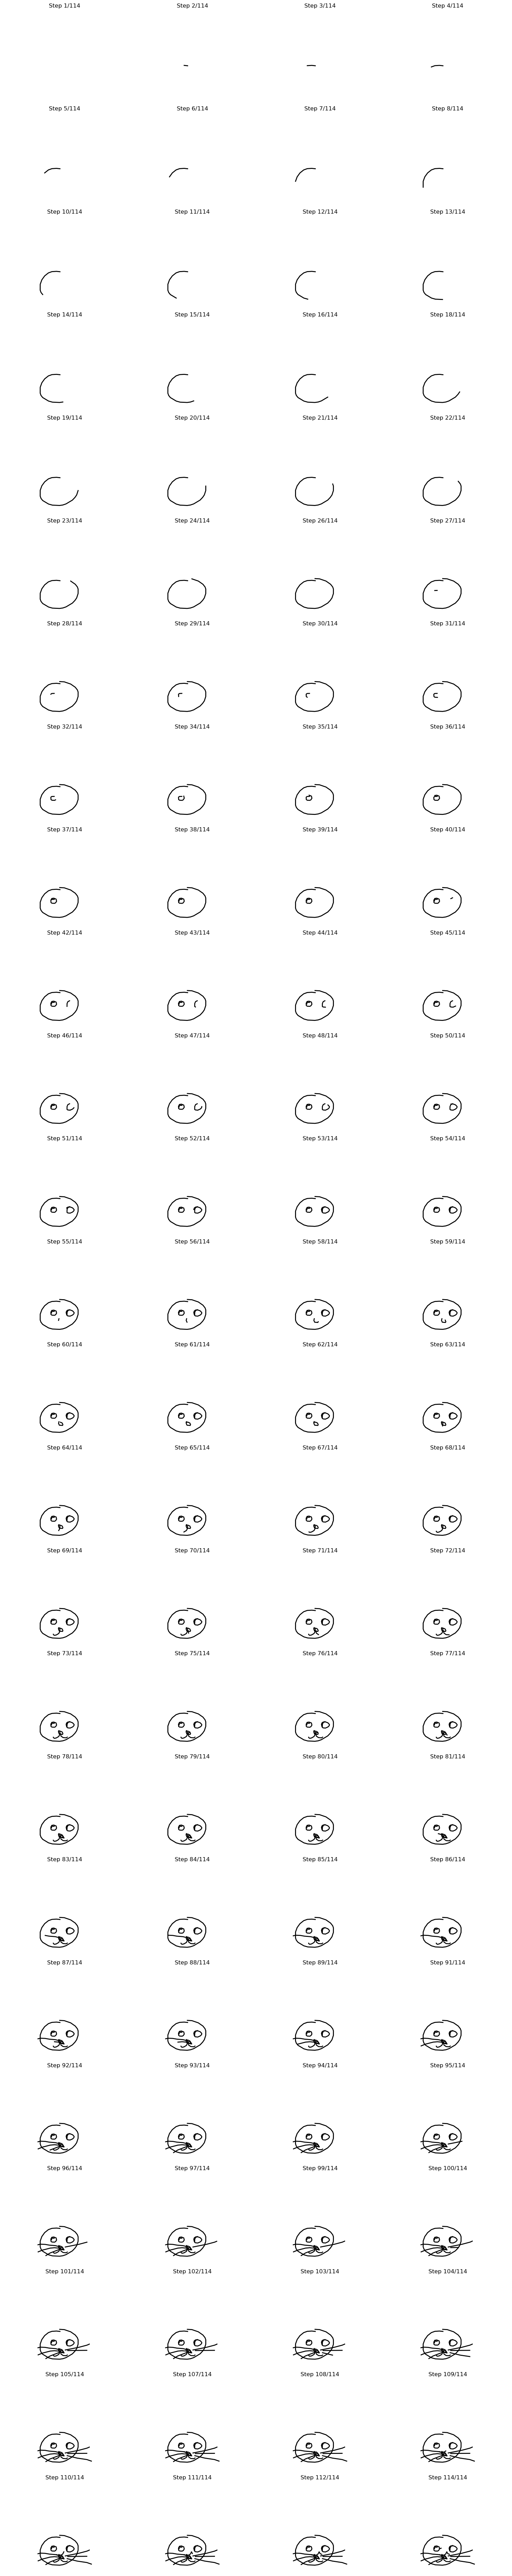

In [38]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display

class Encoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.rnn = nn.GRU(5, self.hidden_size, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc_mu = nn.Linear(2 * self.hidden_size, self.z_size)
        self.fc_logvar = nn.Linear(2 * self.hidden_size, self.z_size)
        
    def forward(self, inputs):
        _, hidden = self.rnn(inputs)
        # hidden is of shape (num_layers * num_directions, batch, hidden_size)
        hidden_cat = torch.cat(hidden.split(1, 0), 2).squeeze(0)
        mu = self.fc_mu(hidden_cat)
        logvar = self.fc_logvar(hidden_cat)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size=256, z_size=128, dropout=0.0):
        super(Decoder, self).__init__()
        self.rnn = nn.GRU(z_size + 5, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(z_size, hidden_size)
        
    def init_state(self, z):
        # Create an initial hidden state from z
        return torch.tanh(self.fc(z).unsqueeze(0))
    
    def forward(self, inputs, z):
        hidden = self.init_state(z)
        zs = z.unsqueeze(1).expand(-1, inputs.size(1), -1)
        inputs_z = torch.cat([inputs, zs], dim=2)
        return self.rnn(inputs_z, hidden)

class SketchRNN(nn.Module):
    def __init__(self, enc_hidden_size=256, dec_hidden_size=512, z_size=128, dropout=0.0, M=20):
        super(SketchRNN, self).__init__()
        self.dec_hidden_size = dec_hidden_size
        self.M = M
        self.encoder = Encoder(enc_hidden_size, z_size, dropout)
        self.decoder = Decoder(dec_hidden_size, z_size, dropout)
        self.gmm = nn.Linear(dec_hidden_size, 6 * M + 3)
        
    def forward(self, inputs):
        enc_inputs = inputs[:, 1:, :]
        mu, logvar = self.encoder(enc_inputs)
        z = self.reparameterize(mu, logvar)
        
        dec_inputs = inputs[:, :-1, :]
        outputs, _ = self.decoder(dec_inputs, z)
        outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
        
        return z, mu, logvar, o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu
        
    def get_mixture_coef(self, outputs):
        z_pen_logits = outputs[:, 0:3]  # pen state logits
        z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.split(outputs[:, 3:], self.M, 1)
        
        # Softmax the pi's and pen states
        z_pi = F.softmax(z_pi, dim=1)
        z_pen = F.softmax(z_pen_logits, dim=1)
        
        # Exponentiate sigmas and constrain corr between -1 and 1.
        z_sigma1 = torch.exp(z_sigma1)
        z_sigma2 = torch.exp(z_sigma2)
        z_corr = torch.tanh(z_corr)
        
        return z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen, z_pen_logits
    
    def generate_step_by_step(self, seq_len=250, z=None, temperature=0.6):
        """
        Generate a sketch one stroke at a time
        
        Args:
            seq_len: Maximum sequence length to generate
            z: Latent vector (if None, a random one will be generated)
            temperature: Controls randomness (lower = more deterministic)
            
        Returns:
            Array of strokes, each containing [dx, dy, pen_down, pen_up, pen_end]
        """
        device = next(self.parameters()).device
        
        # Generate a random latent vector if not provided
        if z is None:
            z = torch.randn(1, 128, device=device)
        
        # Start with initial stroke [0, 0, 1, 0, 0]
        sample = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32, 
                              device=device).view(1, 1, 5)
        hidden = self.decoder.init_state(z)
        
        # Lists to store the generated strokes
        all_strokes = []
        
        # Helper function for bivariate normal distribution sampling
        def bivariate_normal(m1, m2, s1, s2, rho, temp=1.0):
            mean = [m1, m2]
            s1 = s1 * (temp ** 2)
            s2 = s2 * (temp ** 2)
            cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
            sample_np = np.random.multivariate_normal(mean, cov, 1, check_valid='ignore')
            return sample_np[0][0], sample_np[0][1]
        
        # Helper function to adjust temperature for sampling
        def adjust_temp(pdf):
            pdf = torch.log(pdf) / temperature
            pdf = pdf - torch.max(pdf)
            pdf = torch.exp(pdf)
            pdf = pdf / torch.sum(pdf)
            return pdf
        
        # Generate strokes one by one
        for _ in range(seq_len):
            inputs = sample[:, -1:, :]
            inputs_z = torch.cat([inputs, z.unsqueeze(1)], dim=2)
            outputs, hidden = self.decoder.rnn(inputs_z, hidden)
            outputs = self.gmm(outputs.contiguous().view(-1, self.dec_hidden_size))
            o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits = self.get_mixture_coef(outputs)
            
            state = torch.zeros(1, 1, 5, device=device)
            pen_status = torch.distributions.Categorical(adjust_temp(o_pen.view(-1))).sample().item()
            state[:, :, pen_status + 2] = 1  # Set the pen state
            
            M_id = torch.distributions.Categorical(adjust_temp(o_pi.view(-1))).sample().item()
            mu_1 = o_mu1[0, M_id].item()
            mu_2 = o_mu2[0, M_id].item()
            sigma_1 = o_sigma1[0, M_id].item()
            sigma_2 = o_sigma2[0, M_id].item()
            corr = o_corr[0, M_id].item()
            
            x, y = bivariate_normal(mu_1, mu_2, sigma_1, sigma_2, corr, temp=temperature)
            state[:, :, 0] = x
            state[:, :, 1] = y
            
            # Store the current stroke
            all_strokes.append(state.cpu().numpy()[0, 0])
            
            # Add the new stroke to the sample
            sample = torch.cat([sample, state], dim=1)
            
            # Stop if pen_status indicates end of drawing
            if pen_status == 2:
                break
        
        # Convert to numpy array for easier handling
        all_strokes = np.array(all_strokes)
        
        return all_strokes

def visualize_step_by_step_snapshots(strokes, num_snapshots=8):
    """
    Visualize the sketch generation process as a series of snapshots
    
    Args:
        strokes: Array of strokes (dx, dy, pen_down, pen_up, pen_end)
        num_snapshots: Number of snapshots to display
    """
    # Calculate absolute coordinates
    x_coords = np.cumsum(strokes[:, 0])
    y_coords = np.cumsum(strokes[:, 1])
    
    # Calculate snapshot indices
    total_strokes = len(strokes)
    snapshot_indices = [int(i * total_strokes / num_snapshots) for i in range(num_snapshots)]
    if snapshot_indices[-1] != total_strokes - 1:
        snapshot_indices[-1] = total_strokes - 1
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 3 * ((num_snapshots + 3) // 4)))
    gs = GridSpec(nrows=(num_snapshots + 3) // 4, ncols=4, figure=fig)
    
    # Set common min/max for all plots
    x_min, x_max = min(x_coords) - 5, max(x_coords) + 5
    y_min, y_max = min(y_coords) - 5, max(y_coords) + 5
    
    # Create snapshots
    for i, idx in enumerate(snapshot_indices):
        ax = fig.add_subplot(gs[i // 4, i % 4])
        
        # Get coordinates up to current snapshot
        x = x_coords[:idx+1]
        y = y_coords[:idx+1]
        
        # Check pen states to determine where to break the line
        pen_states = strokes[:idx+1, 2:5]
        
        # Find indices where pen is lifted (pen_up = 1)
        breaks = np.where(pen_states[:, 1] == 1)[0]
        
        # If there are breaks, draw multiple line segments
        if len(breaks) > 0:
            segments_x = []
            segments_y = []
            
            start_idx = 0
            for break_idx in breaks:
                if break_idx > start_idx:
                    segments_x.append(x[start_idx:break_idx+1])
                    segments_y.append(y[start_idx:break_idx+1])
                start_idx = break_idx + 1
            
            # Add the last segment if it exists
            if start_idx < len(x):
                segments_x.append(x[start_idx:])
                segments_y.append(y[start_idx:])
            
            # Draw all segments
            for seg_x, seg_y in zip(segments_x, segments_y):
                ax.plot(seg_x, -seg_y, 'k-', lw=2)  # Negate y for proper orientation
        else:
            ax.plot(x, -y, 'k-', lw=2)  # Negate y for proper orientation
        
        # Set consistent limits and remove axes
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.axis('off')
        ax.set_title(f'Step {idx+1}/{total_strokes}')
    
    plt.tight_layout()
    return fig

def generate_and_visualize_snapshots(model, seq_len=250, temperature=0.6, num_snapshots=8):
    """
    Generate a sketch and visualize it as a series of snapshots
    
    Args:
        model: The trained SketchRNN model
        seq_len: Maximum sequence length to generate
        temperature: Controls randomness (lower = more deterministic)
        num_snapshots: Number of snapshots to display
    """
    model.eval()
    
    # Generate a random latent vector
    device = next(model.parameters()).device
    z_sample = torch.randn(1, 128, device=device)
    
    # Generate the sketch
    strokes = model.generate_step_by_step(seq_len, z_sample, temperature)
    
    # Visualize the snapshots
    fig = visualize_step_by_step_snapshots(strokes, num_snapshots)
    display(fig)
    plt.close(fig)
    
    return strokes

def main():
    # Create and load the model
    model = SketchRNN()
    model.load_state_dict(torch.load('model_full.pth', map_location='cpu', weights_only=True))
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Generate and visualize snapshots
    generate_and_visualize_snapshots(model, num_snapshots=100)

if __name__ == "__main__":
    main()
